 # Assignment 2 - Modern CNNs (AlexNet)
*This notebook was run by Arsyi Syarief Aziz (H071191003) for the Introduction to Deep Learning course (Unhas) taught by Dr. Risman Adnan.*

This is the first part of this week's assigment. In this notebook, I will attempt to recreate AlexNet.

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.optim as optim
import torch.nn.functional as F

In [2]:
cuda = torch.device('cuda')

## Importing Dataset

I will use the MNIST dataset to train and test the model in this notebook. Because MNIST contains images of shape 28x28 pixels and because AlexNet accepts images of size 244x244 pixels, I will upscale each image in the dataset to 244x244 pixels.

In [3]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Resize(224)])
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Resize(224)]) # Upscale to 244x224 pixels
)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
train_loader = torch.utils.data.DataLoader(
                 dataset=training_data,
                 batch_size=512,
                 shuffle=True,
                 num_workers=2,
                 pin_memory=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_data,
                batch_size=512,
                shuffle=False,
                num_workers=2,
                pin_memory=True)

Viewing samples of the dataset

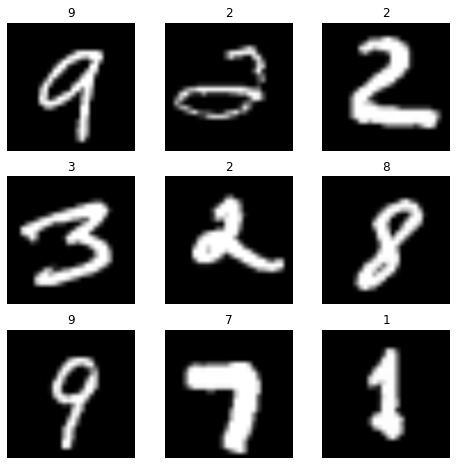

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Definining Helper Functions

This function will be used to train a neural network

In [6]:
def train(net, train_loader, epochs=10, lr=0.001, momentum=0.9, weight_decay=0.0005): 

    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    criterion = nn.CrossEntropyLoss()

    net.to(cuda)
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0

        net.train()
        for X, y in train_loader:
            X, y = X.to(cuda), y.to(cuda)

            # zero the parameter gradients
            optimizer.zero_grad(set_to_none=True)

            # forward + backward + optimize
            outputs = net(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        print(f'Epoch: {epoch + 1}, loss: {running_loss / len(train_loader.dataset):.6f}')

    print('Finished Training')
    total, correct = test(net, train_loader)
    print(f'Train accuracy: {(correct/total)*100}%')

This function will be used to visualize a neural network's prediction on n-samples of a dataset and calculate its overall accuracy.

In [7]:
def test(net, test_loader):
    
    total = 0
    correct = 0

    for X, y in test_loader:
        net.eval()
        X, y = X.to(cuda), y.to(cuda)

        y_hat = net(X).argmax(axis=1)
        total += X.shape[0]
        correct += (y_hat == y).sum()

    return total, correct
  

## AlexNet

The first architecture that I will implement is AlexNet. This architecture is similar to LeNet, but has more convolutional layers; consisting of five convolutional layers and three fully connected layers.

The first convolution layer filters a 244x244 pixel image against 96 kernels of size 11x11 with a stride of 4 pixels. The second convolutional layer takes the output of the previous layer and filters it against 256 kernels of size 5x5 and max pools it against a kernel of size 3x3. Unlike the first and second convolutional layers, the third and fourth layers don't have any max pooling layers. The third convolutional layer filters the previous layer's output against 384 kernels of size 3x3, and the fourth convolutional layer filters the third layer's output against 384 kernels of size 3x3. Continuing on, the output of the fourth layer is inputted into the fifth convolutional layer with 256 kernels of size 3x3, which is then max pooled with a kernel of size 3x3. Finally, the output of the previous layer is inputted into three fully connected layers, each containing 4096 neurons.

In [8]:
alex_net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 10)
)

In [9]:
train(alex_net, train_loader, lr=0.01, epochs=10) 

Epoch: 1, loss: 0.004524
Epoch: 2, loss: 0.004491
Epoch: 3, loss: 0.004524
Epoch: 4, loss: 0.004410
Epoch: 5, loss: 0.001203
Epoch: 6, loss: 0.000251
Epoch: 7, loss: 0.000172
Epoch: 8, loss: 0.000138
Epoch: 9, loss: 0.000116
Epoch: 10, loss: 0.000100
Finished Training
Train accuracy: 98.81999969482422%


In [10]:
total, correct = test(alex_net, test_loader)  

In [11]:
print(f"Test Accuracy: {(correct/total)*100}% ({correct}/{total})")

Test Accuracy: 98.7699966430664% (9877/10000)


In [12]:
def viz_results(net, dataset, num_samples=5):
    net.cpu()
    for i, (x, y) in enumerate(iter(dataset), 1):
        if i <= num_samples:
            
            x, y = x, y
            x = x.reshape(1, 1, x.shape[1], x.shape[2])

            y_hat = net(x).argmax()

            plt.imshow(x.reshape(x.shape[1], x.shape[2], -1).squeeze())
            plt.title(f'{i}. Actual: {y}; Predicted: {y_hat}')
            plt.show()
        else:
            break

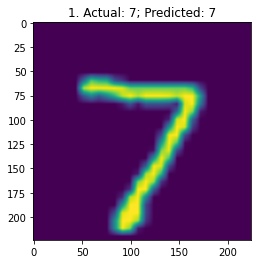

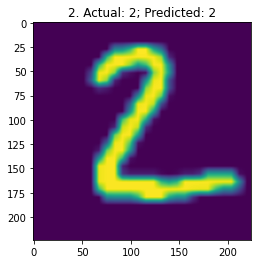

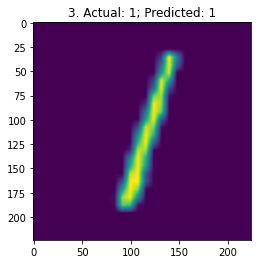

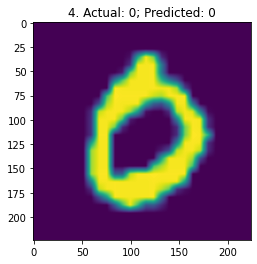

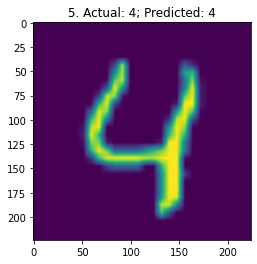

In [13]:
viz_results(alex_net, test_data)